In [1]:
##install necessary packages

!pip install neuromaps
!pip install nilearn
!pip install surfplot
!pip install netneurotools
!pip install matplotlib



In [1]:

import pandas as pd
from nilearn.image import get_data, load_img, new_img_like,resample_to_img
from nilearn.datasets import fetch_atlas_schaefer_2018
from scipy.spatial.distance import squareform, pdist
import numpy as np
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import stats
import matplotlib.pyplot as plt
from netneurotools import datasets, utils, plotting
from scipy import stats
import seaborn as sns



wdir = '/project/sudmexconn/'
n_perm = 10000

    # files needed to run
    #   - subcortical parcellation
    #   - brain data
    #   - receptor data table

In [1]:

#------------------------------------------------------------------------------
# Parcellation
#------------------------------------------------------------------------------
schaefer_fs = datasets.fetch_schaefer2018(version='fsaverage')['400Parcels7Networks']
schaefer_fs = neuromaps.images.annot_to_gifti(schaefer_fs)

schaefer_mni152 = fetch_atlas_schaefer_2018(n_rois=400)
ncorticalnodes = len(schaefer_mni152['labels'])

cort_img = load_img(schaefer_mni152['maps'])
cort_data = get_data(cort_img).astype(int)

# Adjusted file path for Google Drive access
subcort_img = load_img('/content/drive/My Drive/project/sudmexconn/Tian_Subcortex_S2_3T.nii')
subcort_data = get_data(subcort_img).astype(int)
nsubcortnodes = len(np.unique(subcort_data[subcort_data!=0]))

# combine cortical and subcortical
subcort_img_resample =resample_to_img(subcort_img, cort_img, interpolation='nearest', copy=True, order='F', clip=False, fill_value=0, force_resample=False)
subcort_data_resample = get_data(subcort_img_resample).astype(int)
cort_subcort_data = np.copy(cort_data)
cort_subcort_data[subcort_data_resample!=0] = subcort_data_resample[subcort_data_resample!=0]+400

cort_subcort_filename = '/content/drive/My Drive/project/sudmexconn/Schaefer400_17networks_FSLMNI_2m_TianSubCortex_S2_3T.nii.gz'
cort_subcort_img = new_img_like(cort_img, cort_subcort_data, affine=cort_img.affine, copy_header=True).to_filename(cort_subcort_filename)

nnodes = len(np.unique(cort_subcort_data[cort_subcort_data!=0]))


In [ ]:
#------------------------------------------------------------------------------
# NBS brain data
#------------------------------------------------------------------------------

nsb_neg = pd.read_csv('/content/drive/My Drive/project/sudmexconn/degree05neg_230825.csv')
nsb_neg = nsb_neg['x'].values

nsb_pos = pd.read_csv('/content/drive/My Drive/project/sudmexconn/degree05pos_230825.csv')
nsb_pos = nsb_pos['x'].values

nsb_total =  nsb_neg +nsb_pos #change if you wanna look at negative or positive alone

nsb_data = {'both': nsb_total}




**This next part of the code checks if postive and negative degree are correlated (per reviewer's suggestion):**

In [ ]:
# spin test - cortical 
rotated_cort = neuromaps.nulls.vasa(nsb_pos[:ncorticalnodes], atlas='fsaverage', density='164k', 
                               parcellation = schaefer_fs,n_perm=n_perm, seed=1234) # returns nnodes x nperms 

# random shuffling per hemisphere - subcortical
rotated_sub = np.zeros((nsubcortnodes,n_perm))
np.random.seed(seed=1234)
for p in range(n_perm):
    rotated_sub_idx = np.concatenate((np.random.permutation(np.arange(ncorticalnodes,ncorticalnodes + nsubcortnodes/2)).astype(int), np.random.permutation(np.arange(ncorticalnodes + nsubcortnodes/2,ncorticalnodes + nsubcortnodes)).astype(int)))
    rotated_sub[:,p] = nsb_pos[rotated_sub_idx]

# combine
rotated = np.concatenate((rotated_cort,rotated_sub))
corr, pval, null = neuromaps.stats.compare_images(nsb_pos, nsb_neg, 
                                                  nulls=rotated, metric = 'spearmanr', return_nulls=True)

# Scatter plot of the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=nsb_neg, y=nsb_pos, color="blue", marker="+")
plt.title(f'Scatter Plot of nsb_neg vs. nsb_pos (Spearman Corr: {corr:.4f})')
plt.xlabel('nsb_neg')
plt.ylabel('nsb_pos')
sns.regplot(x=nsb_neg, y=nsb_pos, scatter=False, color="red")  # Line of best fit
plt.show()

# Histogram of permutation test results
plt.figure(figsize=(5, 5))
sns.histplot(null, kde=True, color="blue", element="step", stat="density")
plt.axvline(x=corr, color='r', linestyle='--', label=f'Observed Correlation: {corr:.2f}')
plt.title('Permutation Test for nsb_neg vs. nsb_pos Correlation (Spearman)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate p-value
#p_value = pval #np.mean(perm_corrs >= observed_corr)
if pval < 0.0001:  # Use scientific notation if the p-value is very small
    print(f"P-value from permutation test: {p_value:.1e}")
else:
    print(f"P-value from permutation test: {p_value:.4f}")

In [ ]:

#------------------------------------------------------------------------------
# Receptors - parcellate
#------------------------------------------------------------------------------

# MNI152 maps should only be used for subcortical data. warnings.warn('Data from beliveau2017 and norgaard2021 is best used in'
receptor_metadata = pd.read_csv('/content/drive/My Drive/project/sudmexconn/receptors_table_uptodate.csv')

parcellated_receptors_data = dict()
parcellated_receptors_data_zscore = dict()
for index, row in receptor_metadata.iterrows():
    print(row['desc'], row['source'])

    if row['Jocelyn_paper']=='y':
        receptor = neuromaps.datasets.fetch_annotation(source=row['source'],desc=row['desc'], space = row['space'])


        if row['space'] == 'MNI152':
            parcellater = Parcellater(cort_subcort_filename, 'MNI152')
            data = parcellater.fit_transform(receptor, 'MNI152', True)

        if row['space'] == 'fsaverage':

            data = np.zeros(nnodes)
            #cortical
            parcellater = Parcellater(schaefer_fs, 'fsaverage')
            data[:ncorticalnodes] = parcellater.fit_transform(receptor, 'fsaverage', True)

            #subcortical
            receptor_subcort = neuromaps.datasets.fetch_annotation(source=row['source'],desc=row['desc'], space = 'MNI152') # get subcortical in volume space
            parcellater = Parcellater(cort_subcort_filename, 'MNI152')
            data[ncorticalnodes:] = parcellater.fit_transform(receptor_subcort, 'MNI152', True)[:,ncorticalnodes:]

        parcellated_receptors_data[row['neurotransmitter'] + '_' + row['receptor'] + '_' + row['source'] + '_' + row['desc']] = np.reshape(data,-1)
        parcellated_receptors_data_zscore[row['neurotransmitter'] + '_' + row['receptor'] + '_' + row['source'] + '_' + row['desc']] = stats.zscore(np.reshape(data,-1))

parcellated_receptors_data_df = pd.DataFrame(parcellated_receptors_data, index=np.arange(0,nnodes))
parcellated_receptors_data_zscore_df = pd.DataFrame(parcellated_receptors_data_zscore, index=np.arange(0,nnodes))

parcellated_receptors_data_df.to_csv('/content/drive/My Drive/project/sudmexconn/receptors_Schaefer400Tian32_cocaine.csv')
parcellated_receptors_data_zscore_df.to_csv('/content/drive/My Drive/project/sudmexconn/receptors_Schaefer400Tian32_zscore_cocaine.csv')


parcellated_receptor_metadata = receptor_metadata.iloc[np.where(receptor_metadata['Jocelyn_paper']=='y')]
parcellated_receptor_metadata = parcellated_receptor_metadata.reset_index(drop=True)
parcellated_receptor_metadata = parcellated_receptor_metadata.iloc[:, : 7]
neurotransmitter_names = np.unique(parcellated_receptor_metadata['neurotransmitter'])



**Receptor density correlations:**

In [1]:
#----------------------------------------------------------------------------
# Receptor x brain correlation  -- takes the longest!
#----------------------------------------------------------------------------

print(f'--- Correlation with spins tests for cortical and subcortical ---')
null_dict = dict()
# ... should we zscore receptor data? yes. use first one "parcellated_receptors_data_zscore_df"
parcellated_receptors_data_array = parcellated_receptors_data_zscore_df.to_numpy() #if yes
#parcellated_receptors_data_array = parcellated_receptors_data_df.to_numpy() #if no

for i, direction in enumerate(nsb_data): #nsb_data

    brain_phenotype = nsb_data[direction]
    stats = np.zeros((len(parcellated_receptor_metadata), nnodes))

    # spin test - cortical
    rotated_cort = neuromaps.nulls.vasa(brain_phenotype[:ncorticalnodes], atlas='fsaverage', density='164k',
                                   parcellation = schaefer_fs,n_perm=n_perm, seed=1234) # returns nnodes x nperms

    # random shuffling per hemisphere - subcortical
    rotated_sub = np.zeros((nsubcortnodes,n_perm))
    np.random.seed(seed=1234)
    for p in range(n_perm):
        rotated_sub_idx = np.concatenate((np.random.permutation(np.arange(ncorticalnodes,ncorticalnodes + nsubcortnodes/2)).astype(int), np.random.permutation(np.arange(ncorticalnodes + nsubcortnodes/2,ncorticalnodes + nsubcortnodes)).astype(int)))
        rotated_sub[:,p] = brain_phenotype[rotated_sub_idx]

    # combine
    rotated = np.concatenate((rotated_cort,rotated_sub))

    # compute corr and pval
    for index, row in parcellated_receptor_metadata.iterrows():

        corr, pval, null = neuromaps.stats.compare_images(brain_phenotype, parcellated_receptors_data_array[:,index],
                                                          nulls=rotated, metric = 'spearmanr', return_nulls=True)
        print('\n',row['neurotransmitter'], row['receptor'], row['desc'], row['source'], f'\tr = {corr:.03f}, p = {pval:.04f}')

        if pval < 0.05:
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']] = dict()
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['null'] = null
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['pval'] = pval
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['corr'] = corr

        stats[index,0] = corr
        stats[index,1] = pval

    # save corr and pval in metadata table
    parcellated_receptor_metadata['nsb_' + direction + '_corr_z'] = stats[:,0]
    parcellated_receptor_metadata['nsb_' + direction + '_pval_z'] = stats[:,1]

print('**warning: no correction for multiple comparisons applied**')




In [1]:
#----------------------------------------------------------------------------
# Generate d2/3 receptor plots
#----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="ticks")

# Create an empty list to store the data for the raincloud plot
data_x = []

# Combine features (null distributions) in a list
fig, ax = plt.subplots(figsize=(12, 6))

# Create a list of colors for the scatter plots based on the number of features you have
scatter_color = 'indigo'
# Create a list of colors for the violin plots based on the number of features you have
violin_color = 'indigo'
# Create a list of colors for the boxplots based on the number of features you have
boxplot_color = 'mediumpurple'

# Iterate over each receptor and its corresponding null distribution
xlabels = []
i=0
for (index, row) in parcellated_receptor_metadata.iterrows():

    if row['receptor'] == 'D2':
        null_distribution = null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['null']
        corr_value = null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['corr']

        xlabels.append(row['source'])
        # Apply random noise on each sample of the null distribution so they don't overlap on the x-axis in the scatter plot
        idxs = np.arange(len(null_distribution))
        out = null_distribution.astype(float)
        out.flat[idxs] += np.random.uniform(low=-0.005, high=0.005, size=len(idxs))
        null_distribution = out

        # Append the null distribution to the list of data for the raincloud plot
        data_x.append(null_distribution)

        # Boxplot data without outliers
        bp = ax.boxplot(null_distribution, positions=[i + 1], patch_artist=True, vert=True, showfliers=False, widths=0.105)

        # Set the facecolor of the box patches to 'none'
        for patch in bp['boxes']:
            patch.set_facecolor('none')

        # Change the edgecolor of the box patches to 'black'
        for patch in bp['medians']:
            patch.set_color('black')

        # Violinplot data without outliers
        vp = ax.violinplot(null_distribution, positions=[i + 1.08], points=1000, showmeans=False, showextrema=False,
                           showmedians=False, vert=True)

        for b in vp['bodies']:
            # Get the center of the plot
            m = np.mean(b.get_paths()[0].vertices[:, 1])

            # Modify paths to display only the right half of the violin plot
            path = b.get_paths()[0]
            vertices = path.vertices.copy()
            vertices[:, 0] = np.clip(vertices[:, 0], i + 1.1, i + 2)
            path.vertices = vertices

            # Change to the desired color and increase color intensity
            b.set_color(violin_color)
            b.set_alpha(0.75)

        # Scatterplot data
        x = np.full(len(null_distribution), i + 1.017)
        idxs = np.arange(len(x))
        out = x.astype(float)
        out.flat[idxs] += np.random.uniform(low=-0.05, high=0.015, size=len(idxs))
        x = out
        plt.scatter(x, null_distribution, s=0.05, c=scatter_color, linewidths=None, alpha=0.2)

        # Highlight 'corr' value with a red point and add a black circle around it
        plt.scatter(i + 1, corr_value, color='red', marker='o', s=150, label='corr', edgecolors='black', linewidths=2, zorder=100)
        # Add text with 'corr' value next to the point
        plt.text(i + 1.2, corr_value, f'{corr_value:.3f}', color='black', va='center', fontsize=17)

        i = i+1
plt.xticks(np.arange(1, len(data_x) + 1, 1), xlabels, fontsize=17)
plt.ylabel('Correlation (spearman rho)', fontsize=17)
plt.xlabel('Receptor Source', fontsize=17)
plt.title("Associations between brain dysfunction cortical and subcortical and D2 receptor density", fontsize=17)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

#plt.savefig('fig2sudmex_nulldistribution_231020_corticalonly.svg', format='svg')
plt.show()

In [1]:

#----------------------------------------------------------------------------
# Generate scatterplots for d2/3 receptor plots
#----------------------------------------------------------------------------

import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np


# Define colors for each source
colors = {
    'smith2017': 'darkmagenta',
    'sandiego2015': 'forestgreen',
    'jaworska2020': 'dodgerblue'
}

# Specify font family
#mpl.rcParams['font.family'] = 'sans-serif'

# Setup figure and axes
fig, ax = plt.subplots(figsize=(15, 15))
# Select a direction
direction = 'both'
brain_phenotype = nsb_data[direction]

labels_added = []
correlation_values = []

# Loop through the receptor metadata
for i, row in parcellated_receptor_metadata.iterrows():
    if row['receptor'] == 'D2':
        x = parcellated_receptors_data_array[:, i]
        r = row[f'nsb_{direction}_corr_z']
        p = row[f'nsb_{direction}_pval_z']
        source = row['source']
        color = colors.get(source, 'gray')  # Defaults to gray if source not found in colors dict

        # Add label for legend only if it's not already added
        label = f"{row['receptor']} ({source})" if row['receptor'] + ' (' + source + ')' not in labels_added else None
        labels_added.append(row['receptor'] + ' (' + source + ')')

        # Scatter plot
        marker_size = 50 if p < 0.05 else 2  # Emphasize significant points
        ax.scatter(x, brain_phenotype, s=marker_size, color=color, label=label, alpha=0.5)

        # Add regression line
        slope, intercept, _, _, _ = linregress(x, brain_phenotype)
        line_x = np.linspace(min(x), max(x), 100)
        line_y = intercept + slope * line_x
        ax.plot(line_x, line_y, color=color, alpha=0.8)

        # Store correlation for annotation
        correlation_values.append((label, r))

# Adding annotations for correlation
for idx, (label, r) in enumerate(correlation_values):
    ax.annotate(f'{label}: r = {r:.3f}', xy=(1.02, 0.9 - idx * 0.05), xycoords='axes fraction', color='black')

ax.set_xlabel('Receptor Density')
ax.set_ylabel('Total NBS Degree')
ax.set_title('Correlation between D2 Receptor Density and Cocaine NBS Total Degree')

# Adjust legend outside the plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticks(np.arange(0, 151, 10))

plt.tight_layout()
plt.savefig('/content/drive/My Drive/project/fig1-scatter-plot.svg')  # Save the figure as a svg
plt.show()

In [1]:


##----------------------------------------------------------------------------
## Generate plots for scatterplot serotonin supplement
##----------------------------------------------------------------------------


import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Define colors for each source
colors = {
    'beliveau2017': 'darkmagenta',
    'radnakrishnan2018': 'forestgreen',
}

# Setup figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Select a direction
direction = 'both'
brain_phenotype = nsb_data[direction]

labels_added = []
correlation_values = []

# Loop through the receptor metadata
for i, row in parcellated_receptor_metadata.iterrows():
    # Check for '5HT4' or '5HT6'
    if row['receptor'] in ['5HT4', '5HT6']:
        x = parcellated_receptors_data_array[:, i]
        r = row[f'nsb_{direction}_corr_z']
        p = row[f'nsb_{direction}_pval_z']
        source = row['source']
        color = colors.get(source, 'gray')  # Default to gray if source not found in colors dict

        # Add label for legend only if it's not already added
        label = f"{row['receptor']} ({source})" if row['receptor'] + ' (' + source + ')' not in labels_added else None
        labels_added.append(row['receptor'] + ' (' + source + ')')

        # Scatter plot
        marker_size = 50 if p < 0.05 else 2  # Emphasize significant points
        ax.scatter(x, brain_phenotype, s=marker_size, color=color, label=label, alpha=0.5)

        # Add regression line
        slope, intercept, _, _, _ = linregress(x, brain_phenotype)
        line_x = np.linspace(min(x), max(x), 100)
        line_y = intercept + slope * line_x
        ax.plot(line_x, line_y, color=color, alpha=0.8)

        # Store correlation for annotation
        correlation_values.append((label, r))

# Adding annotations for correlation
for idx, (label, r) in enumerate(correlation_values):
    ax.annotate(f'{label}: r = {r:.3f}', xy=(1.02, 0.9 - idx * 0.05), xycoords='axes fraction', color='black')

ax.set_xlabel('Receptor Density')
ax.set_ylabel('Total NBS Degree')
ax.set_title('Correlation between Serotonin Receptor Density and NBS Total Degree')

# Adjust legend outside the plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticks(np.arange(0, 151, 10))

plt.tight_layout()

# Save the figure as an SVG file

plt.show()


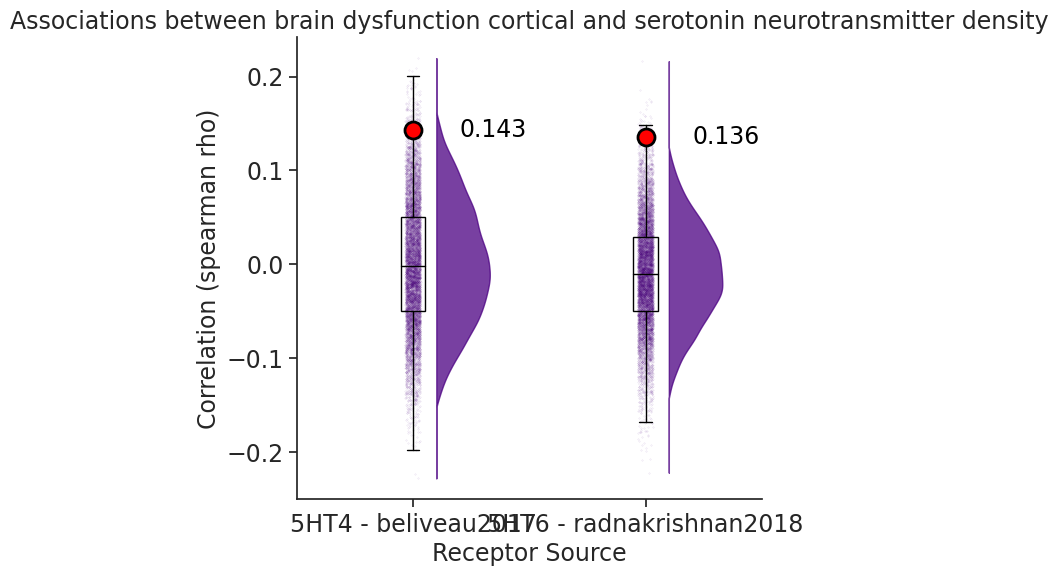

In [ ]:

#----------------------------------------------------------------------------
# Generate plots for serotonin supplement
#----------------------------------------------------------------------------
#
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="ticks")

# Create an empty list to store the data for the raincloud plot
data_x = []

# Combine features (null distributions) in a list
fig, ax = plt.subplots(figsize=(6, 6))

# Create a list of colors for the scatter plots based on the number of features you have
scatter_color = 'indigo'
# Create a list of colors for the violin plots based on the number of features you have
violin_color = 'indigo'
# Create a list of colors for the boxplots based on the number of features you have
boxplot_color = 'mediumpurple'

# Iterate over each receptor and its corresponding null distribution
xlabels = []
i=0
for (index, row) in parcellated_receptor_metadata.iterrows():

    if row['neurotransmitter'] == 'serotonin' and row['nsb_both_pval_z'] < 0.05:
        null_distribution = null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['null']
        corr_value = null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['corr']

        xlabels.append(f"{row['receptor']} - {row['source']}")
        idxs = np.arange(len(null_distribution))
        out = null_distribution.astype(float)
        out.flat[idxs] += np.random.uniform(low=-0.005, high=0.005, size=len(idxs))
        null_distribution = out

        data_x.append(null_distribution)

        bp = ax.boxplot(null_distribution, positions=[i + 1], patch_artist=True, vert=True, showfliers=False, widths=0.105)
        for patch in bp['boxes']:
            patch.set_facecolor('none')
        for patch in bp['medians']:
            patch.set_color('black')

        vp = ax.violinplot(null_distribution, positions=[i + 1.08], points=1000, showmeans=False, showextrema=False,
                           showmedians=False, vert=True)
        for b in vp['bodies']:
            m = np.mean(b.get_paths()[0].vertices[:, 1])
            path = b.get_paths()[0]
            vertices = path.vertices.copy()
            vertices[:, 0] = np.clip(vertices[:, 0], i + 1.1, i + 2)
            path.vertices = vertices
            b.set_color(violin_color)
            b.set_alpha(0.75)

        x = np.full(len(null_distribution), i + 1.017)
        idxs = np.arange(len(x))
        out = x.astype(float)
        out.flat[idxs] += np.random.uniform(low=-0.05, high=0.015, size=len(idxs))
        x = out
        plt.scatter(x, null_distribution, s=0.05, c=scatter_color, linewidths=None, alpha=0.2)

        plt.scatter(i + 1, corr_value, color='red', marker='o', s=150, label='corr', edgecolors='black', linewidths=2, zorder=100)
        plt.text(i + 1.2, corr_value, f'{corr_value:.3f}', color='black', va='center', fontsize=17)

        i = i+1

plt.xticks(np.arange(1, len(data_x) + 1, 1), xlabels, fontsize=17)
plt.ylabel('Correlation (spearman rho)', fontsize=17)
plt.xlabel('Receptor Source', fontsize=17)
plt.title("Associations between brain dysfunction cortical and serotonin neurotransmitter density", fontsize=17) # Modified title
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

#plt.savefig('supps_serotonin_fig2sudmex_nulldistribution_231026_corticalONLY.svg', format='svg')
plt.show()


In [ ]:

#----------------------------------------------------------------------------
# Receptor density x NBS degree for cortical only
#----------------------------------------------------------------------------
#


print(f'--- Correlation with spins tests for cortical ONLY ---')
null_dict = dict()

# zscore receptor data?
parcellated_receptors_data_array = parcellated_receptors_data_zscore_df.to_numpy()

for i, direction in enumerate(nsb_data):

    brain_phenotype = nsb_data[direction][:ncorticalnodes]  # restrict to cortical nodes
    stats = np.zeros((len(parcellated_receptor_metadata), nnodes))

    # spin test - cortical
    rotated_cort = neuromaps.nulls.vasa(brain_phenotype, atlas='fsaverage', density='164k',
                                        parcellation=schaefer_fs, n_perm=n_perm, seed=1234)

    # computer corr and pval
    for index, row in parcellated_receptor_metadata.iterrows():

        # Ensure that you are comparing only the cortical portion of the receptor data
        receptor_data = parcellated_receptors_data_array[:ncorticalnodes, index]

        corr, pval, null = neuromaps.stats.compare_images(brain_phenotype, receptor_data,
                                                          nulls=rotated_cort, metric='spearmanr', return_nulls=True)
        print('\n',row['neurotransmitter'], row['receptor'], row['desc'], row['source'], f'\tr = {corr:.03f}, p = {pval:.04f}')

        if pval < 0.05:
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']] = dict()
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['null'] = null
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['pval'] = pval
             null_dict[row['neurotransmitter']+'_'+row['receptor']+'_'+row['desc']+'_'+row['source']]['corr'] = corr

        stats[index,0] = corr
        stats[index,1] = pval

    # save corr and pval in metadata table
    parcellated_receptor_metadata['nsb_' + direction + '_corr_z'] = stats[:,0]
    parcellated_receptor_metadata['nsb_' + direction + '_pval_z'] = stats[:,1]

print('**warning: no correction for multiple comparisons applied**')


--- Correlation with spins tests for cortical ONLY ---

 acetylcholine A4B2 flubatine hillmer2016 	r = 0.001, p = 0.9870

 acetylcholine M1 lsn3172176 naganawa2020 	r = 0.014, p = 0.8284

 acetylcholine VAChT feobv aghourian2017 	r = -0.023, p = 0.7569

 acetylcholine VAChT feobv bedard2019 	r = 0.044, p = 0.5375

 acetylcholine VAChT feobv tuominen 	r = -0.033, p = 0.6199

 cannabinoid CB1 fmpepd2 laurikainen2018 	r = 0.003, p = 0.9660

 cannabinoid CB1 omar normandin2015 	r = 0.092, p = 0.2576

 dopamine D1 sch23390 kaller2017 	r = 0.058, p = 0.5100

 dopamine D2 fallypride jaworska2020 	r = 0.172, p = 0.0289

 dopamine D2 flb457 sandiego2015 	r = 0.179, p = 0.0183

 dopamine D2 flb457 smith2017 	r = 0.187, p = 0.0132

 dopamine DAT fepe2i sasaki2012 	r = -0.032, p = 0.5636

 gaba GABAa flumazenil dukart2018 	r = 0.074, p = 0.3053

 gaba GABAa-bz flumazenil norgaard2021 	r = -0.072, p = 0.3173

 gutamate mGluR5 abp688 dubois2015 	r = 0.050, p = 0.5404

 gutamate mGluR5 abp688 rosanet

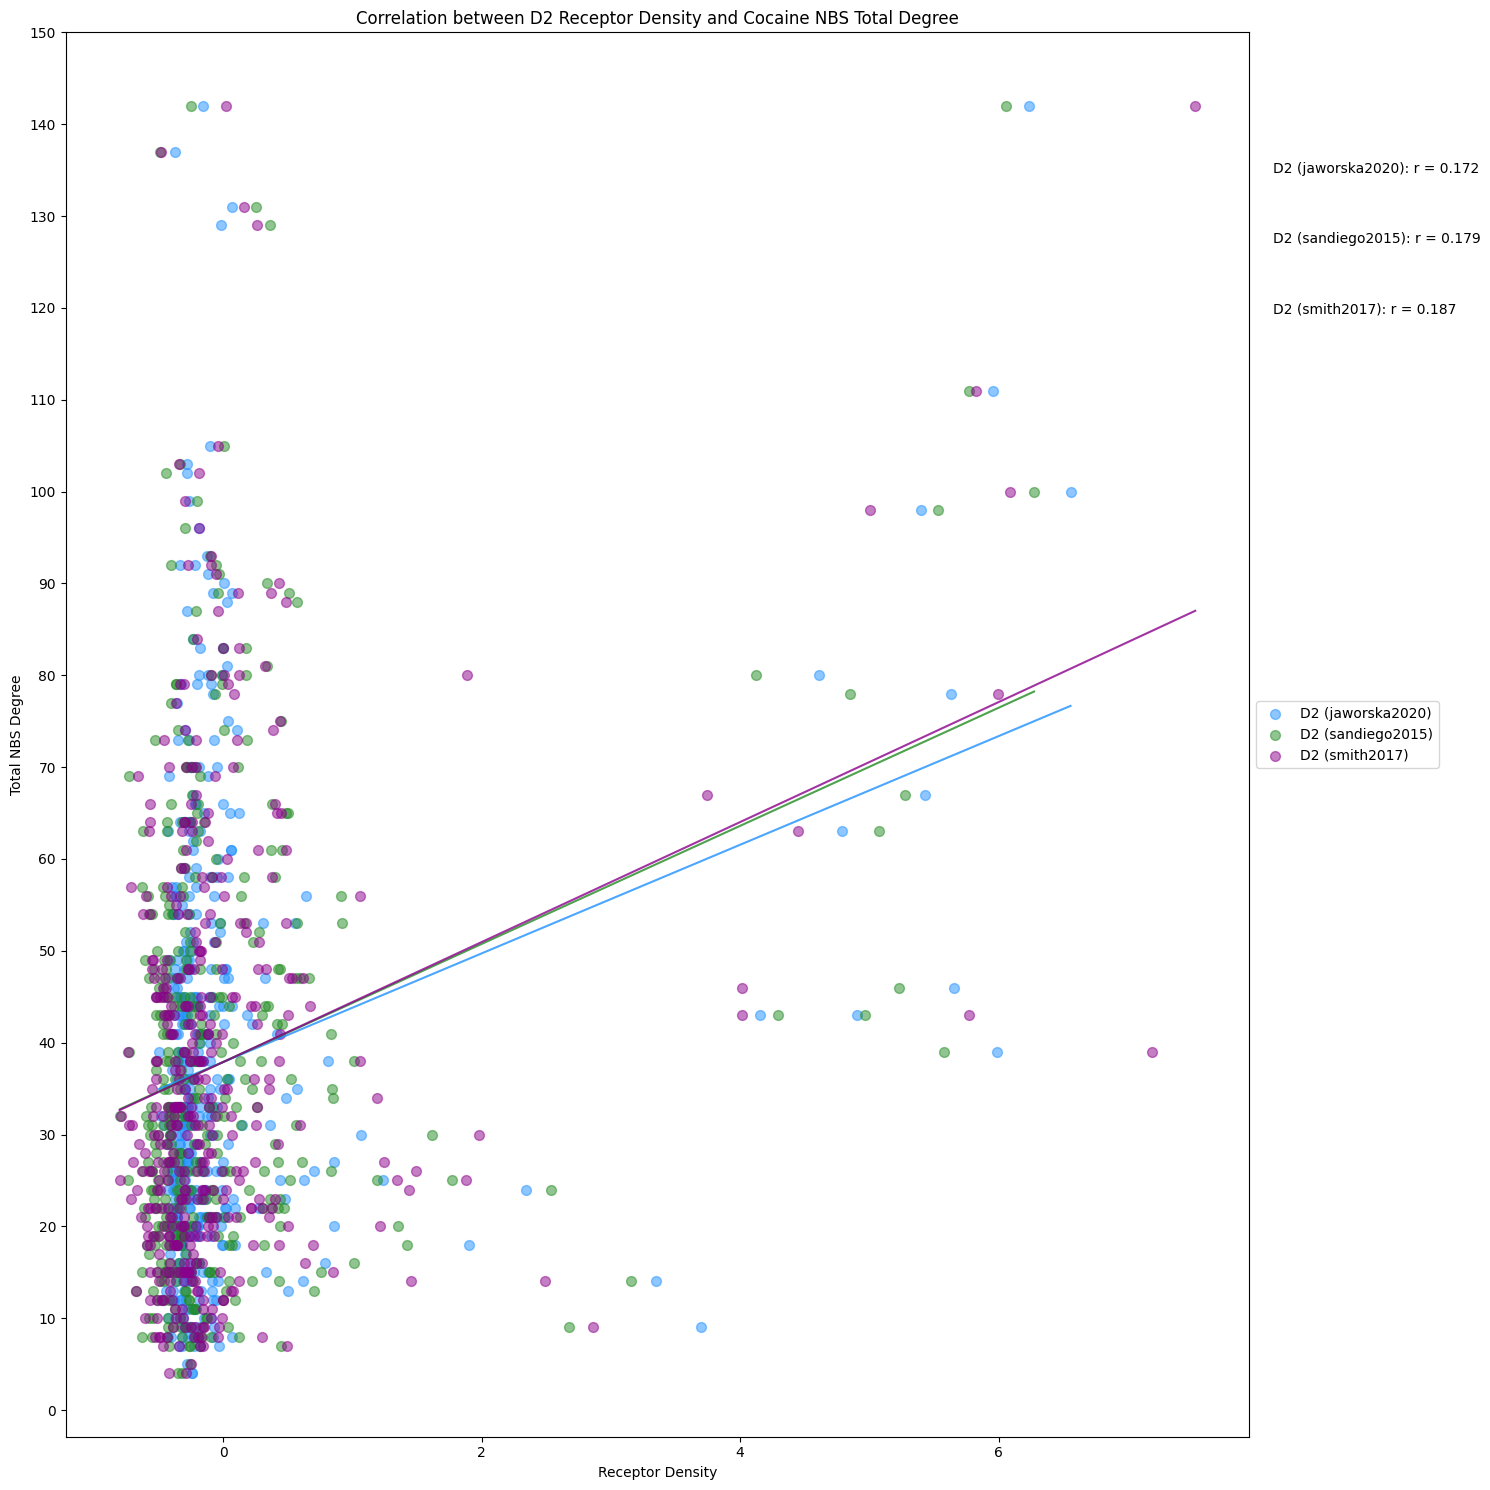

In [ ]:
#----------------------------------------------------------------------------
# Generate scatter plots for cortical only
#----------------------------------------------------------------------------
#

# Define colors for each source
colors = {
    'smith2017': 'darkmagenta',
    'sandiego2015': 'forestgreen',
    'jaworska2020': 'dodgerblue'
}

# Setup figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Select a direction
direction = 'both'
brain_phenotype = nsb_data[direction]

labels_added = []
correlation_values = []

# Loop through the receptor metadata
for i, row in parcellated_receptor_metadata.iterrows():
    if row['receptor'] == 'D2':
        x = parcellated_receptors_data_array[:, i]
        r = row[f'nsb_{direction}_corr_z']
        p = row[f'nsb_{direction}_pval_z']
        source = row['source']
        color = colors.get(source, 'gray')  # Default to gray if source not found in colors dict

        # Add label for legend only if it's not already added
        label = f"{row['receptor']} ({source})" if row['receptor'] + ' (' + source + ')' not in labels_added else None
        labels_added.append(row['receptor'] + ' (' + source + ')')

        # Scatter plot
        marker_size = 50 if p < 0.05 else 2  # Emphasize significant points
        ax.scatter(x, brain_phenotype, s=marker_size, color=color, label=label, alpha=0.5)

        # Add regression line
        slope, intercept, _, _, _ = linregress(x, brain_phenotype)
        line_x = np.linspace(min(x), max(x), 100)
        line_y = intercept + slope * line_x
        ax.plot(line_x, line_y, color=color, alpha=0.8)

        # Store correlation for annotation
        correlation_values.append((label, r))

# Adding annotations for correlation
for idx, (label, r) in enumerate(correlation_values):
    ax.annotate(f'{label}: r = {r:.3f}', xy=(1.02, 0.9 - idx * 0.05), xycoords='axes fraction', color='black')

ax.set_xlabel('Receptor Density')
ax.set_ylabel('Total NBS Degree')
ax.set_title('Correlation between D2 Receptor Density and Cocaine NBS Total Degree')

# Adjust legend outside the plot area
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticks(np.arange(0, 151, 10))

plt.tight_layout()
plt.savefig('/content/drive/My Drive/project/fig2-corticalscatter-plot.svg')
plt.show()
